# lstm的demo

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

## define the network

### 原理

<center><img src="lstm.jpg" width="600"></center>


$$
\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}
$$

> 注：上面的下标是指从什么到什么，比如$W_{ii}$表示从输入到输入的权重，$W_{ig}$表示从输入到门的权重，$W_{hg}$表示从隐藏层到门的权重，$W_{ho}$表示从隐藏层到输出的权重，$W_{hf}$表示从隐藏层到遗忘门的权重，$W_{hi}$表示从隐藏层到输入门的权重。$b_{ii}$表示从输入到输入的偏置，$b_{ig}$表示从输入到门的偏置，$b_{hg}$表示从隐藏层到门的偏置，$b_{ho}$表示从隐藏层到输出的偏置，$b_{hf}$表示从隐藏层到遗忘门的偏置，$b_{hi}$表示从隐藏层到输入门的偏置。$i_t$表示输入门，$f_t$表示遗忘门，$g_t$表示门，$o_t$表示输出门，$c_t$表示记忆单元，$h_t$表示隐藏层。

In [2]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()
        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  
        # rnn layer 在自然语言处理中，第一个参数通常是embedding的维度，第二个参数是隐藏层的维度，第三个参数是层数
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim) # y = y.view(seq_len * batch_size, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1) # y = y.view(seq_len, batch_size, out_dim)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc_for_test(self, x, hc):
        # 后面计算loss的时候，需要用到y和hc，所以这里需要单独写一个函数
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc


In [3]:
inp_dim = 3 # 输入维度 我们是（客流量，年，月）三个维度
out_dim = 1 # 输出维度 我们是预测客流量，所以是1
mid_dim = 8 # 隐藏层维度
mid_layers = 1 # 隐藏层层数
batch_size = 12 * 4 # 我们划分成48个batch
mod_dir = '.'

## load data

In [4]:
# passengers number of international airline , 1949-01 ~ 1960-12 per month
seq_number = np.array(
    [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
        114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
        209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
        272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
        302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
        315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
        318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
        348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
        362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
        342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
        417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
        432.], dtype=np.float32)

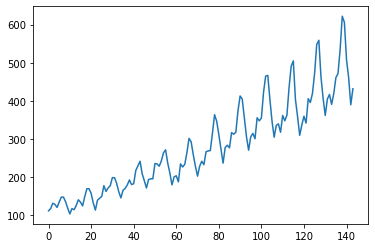

In [5]:
plt.plot(seq_number)

In [6]:
seq_number.shape

(144,)

In [7]:
seq_number = seq_number[:, np.newaxis]

In [8]:
seq_number.shape

(144, 1)

In [9]:
# 1949~1960, 12 years, 12*12==144 month
seq_year = np.arange(12)
seq_month = np.arange(12)
seq_year_month = np.transpose(
    [np.repeat(seq_year, len(seq_month)),
        np.tile(seq_month, len(seq_year))],
)  # Cartesian Product 就是笛卡尔积

In [10]:
seq_year_month.shape

(144, 2)

In [11]:
seq_year_month[:5]

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4]])

In [12]:
seq = np.concatenate((seq_number, seq_year_month), axis=1) # 所以最终的形式是（客流量，年，月） 年和月是0-11的数字

In [13]:
seq[:5]

array([[112.,   0.,   0.],
       [118.,   0.,   1.],
       [132.,   0.,   2.],
       [129.,   0.,   3.],
       [121.,   0.,   4.]])

In [14]:
# normalization
seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)

In [15]:
seq[:5]

array([[-1.40777884, -1.59325501, -1.59325501],
       [-1.35759023, -1.59325501, -1.30357228],
       [-1.24048348, -1.59325501, -1.01388955],
       [-1.26557778, -1.59325501, -0.72420682],
       [-1.33249593, -1.59325501, -0.43452409]])

In [16]:
data = seq
data_x = data[:-1, :]
data_y = data[+1:, 0]
assert data_x.shape[1] == inp_dim

In [17]:
data_x[:5]

array([[-1.40777884, -1.59325501, -1.59325501],
       [-1.35759023, -1.59325501, -1.30357228],
       [-1.24048348, -1.59325501, -1.01388955],
       [-1.26557778, -1.59325501, -0.72420682],
       [-1.33249593, -1.59325501, -0.43452409]])

In [18]:
data_y[:5]

array([-1.35759023, -1.24048348, -1.26557778, -1.33249593, -1.21538918])

In [19]:
data_x.shape

(143, 3)

In [20]:
data_y.shape

(143,)

In [21]:
# split train and test
train_size = int(len(data_x) * 0.75) # 107

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim)) # 107, 3
train_y = train_y.reshape((train_size, out_dim)) # 107, 1
print("train_x.shape: ", train_x.shape)
print("train_y.shape: ", train_y.shape)

train_x.shape:  (107, 3)
train_y.shape:  (107, 1)


### build model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [69]:
from torchinfo import summary
summary(net, input_size=(47, 48, 3))

Layer (type:depth-idx)                   Output Shape              Param #
RegLSTM                                  [47, 48, 1]               --
├─LSTM: 1-1                              [47, 48, 8]               416
├─Sequential: 1-2                        [2256, 1]                 --
│    └─Linear: 2-1                       [2256, 8]                 72
│    └─Tanh: 2-2                         [2256, 8]                 --
│    └─Linear: 2-3                       [2256, 1]                 9
Total params: 497
Trainable params: 497
Non-trainable params: 0
Total mult-adds (M): 1.12
Input size (MB): 0.03
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.34

### train

我们首先制作train的batch，然后训练模型。

制作batch的方法是选取不同开头但截止一样的序列，然后将这些序列组合成一个batch。

<center><img src="lstm_batch.drawio.png" width="600"></center>

In [24]:
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for roi_len in range(batch_size):
    begin_idx = train_size - roi_len # train_size = 107
    batch_var_x.append(var_x[begin_idx:])
    batch_var_y.append(var_y[begin_idx:])

In [25]:
print("var_x.shape: ", var_x.shape)
print("var_y.shape: ", var_y.shape)

var_x.shape:  torch.Size([107, 3])
var_y.shape:  torch.Size([107, 1])


In [30]:
print("batch_var_x[0].shape: ", batch_var_x[0].shape)
print("batch_var_y[0].shape: ", batch_var_y[0].shape)
print("batch_var_x[1].shape: ", batch_var_x[47].shape)
print("batch_var_y[1].shape: ", batch_var_y[47].shape)

batch_var_x[0].shape:  torch.Size([0, 3])
batch_var_y[0].shape:  torch.Size([0, 1])
batch_var_x[1].shape:  torch.Size([47, 3])
batch_var_y[1].shape:  torch.Size([47, 1])


In [29]:
print("batch_var_x.len: ", len(batch_var_x))
print("batch_var_y.len: ", len(batch_var_y))

batch_var_x.len:  48
batch_var_y.len:  48


#### padding

<center><img src="lstm.drawio.png" width="400"></center>

我们看到不同的batch的shape是不一样的，但是我们需要的是一样的，所以我们需要对batch进行padding，即在后面补0，使得所有的batch的shape都一样

In [31]:
from torch.nn.utils.rnn import pad_sequence
batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

这里为损失函数添加了类似遗忘曲线的东西，使得模型在训练的时候不会忘记之前的信息，而是会逐渐遗忘。

$$
weight_t = e * \frac{t}{len(train_y)} \quad \text{where} \quad t \in [0, len(train_y))
$$

In [32]:
print("batch_var_x.shape: ", batch_var_x.shape)
print("batch_var_y.shape: ", batch_var_y.shape)
print("weights.shape: ", weights.shape)

batch_var_x.shape:  torch.Size([47, 48, 3])
batch_var_y.shape:  torch.Size([47, 48, 1])
weights.shape:  torch.Size([107])


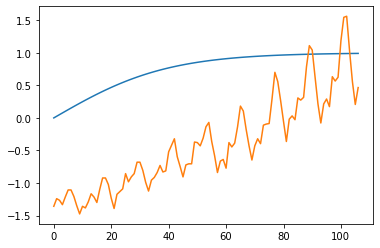

In [60]:
# 画出weights
plt.plot(weights.cpu().numpy())
# 画出客流量
plt.plot(train_y)

In [43]:
batch_var_x[:5, 0, :] # 对应上图的蓝色圆角矩形上方第一行数据前五个

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [45]:
batch_var_x[:5, 1, :]  # 对应上图的蓝色圆角矩形所在行数据前五个

tensor([[0.2066, 0.7242, 1.3036],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

> 注：一个mini_batch最多也只有47个数据，从结尾开始取的，后面我们看能否改进一下

In [63]:
print("Training Start")
for epoch in range(384):
    out = net(batch_var_x)

    # loss = 1/2 * (out - batch_var_y) ** 2 * weights
    loss = (out - batch_var_y) ** 2 * weights
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(epoch, loss.item()))

Training Start
Epoch:    0, Loss: 0.00016
Epoch:   64, Loss: 0.00016
Epoch:  128, Loss: 0.00015
Epoch:  192, Loss: 0.00027
Epoch:  256, Loss: 0.00015
Epoch:  320, Loss: 0.00014


In [64]:
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Save in: ./net.pth


In [65]:
loss

tensor(0.0001, grad_fn=<MeanBackward0>)

### eval

In [70]:
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()

test_x = data_x.copy() # shape (143, 3)
test_x[train_size:, 0] = 0 # 设置为0，表示预测 shape (143, 3)
test_x = test_x[:, np.newaxis, :] # shape (143, 1, 3)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

'''simple way but no elegant'''
# for i in range(train_size, len(data) - 2):
#     test_y = net(test_x[:i])
#     test_x[i, 0, 0] = test_y[-1]

'''elegant way but slightly complicated'''
eval_size = 1
zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)

test_y, hc = net.output_y_hc_for_test(test_x[:train_size], (zero_ten, zero_ten))
test_x[train_size + 1, 0, 0] = test_y[-1]
for i in range(train_size + 1, len(data) - 2):
    test_y, hc = net.output_y_hc_for_test(test_x[i:i + 1], hc)
    test_x[i + 1, 0, 0] = test_y[-1]

pred_y = test_x[1:, 0, 0]
pred_y = pred_y.cpu().data.numpy()

diff_y = pred_y[train_size:] - data_y[train_size:-1]
l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)
print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

L1: 0.193    L2: 0.047


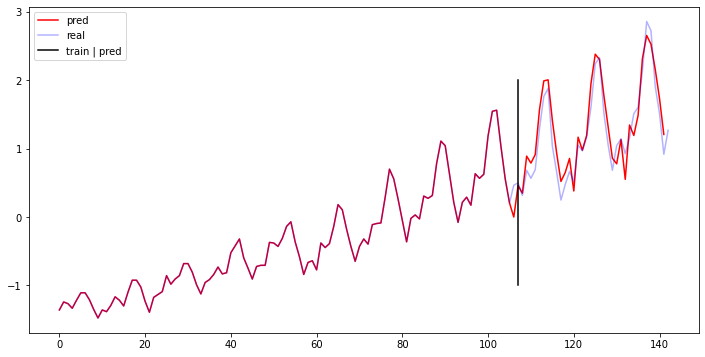

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(pred_y, 'r', label='pred')
plt.plot(data_y, 'b', label='real', alpha=0.3)
plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
plt.legend(loc='best')

In [ ]:
## 2022.2.17到2022.10.29 都是训练集，2022.10.30到2022.12.31都是测试集